## ECE Analysis

In [72]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import re

def analyze_calibration(model, X_test, y_test, model_type, M=15, plot_title="Reliability Diagram", save_plot=False, filename="calibration_plot.png", model_name = "your model"):
    """
    Calculates ECE and generates a Reliability Diagram.
    
    Args:
        model: The trained model (scikit-learn pipeline or Hugging Face model).
        X_test: The test data. Can be an array/matrix or a tf.data.Dataset.
        y_test: The true labels of the test set (array or list).
        model_type (str): 'random_forest' or 'bert' to select the correct prediction logic.
        M (int): Number of bins for ECE calculation.
        plot_title (str): Title of the plot.
        save_plot (bool): If True, saves the plot to a file.
        filename (str): The name of the file to save the plot to.
    """
    
    # Get predictions and probabilities based on model type
    if model_type == 'mlscikit-learn':
        # For Random Forest (scikit-learn)
        y_pred_proba = model.predict_proba(X_test)
        y_pred = model.predict(X_test)
        y_true = np.array(y_test)
    elif model_type == 'bert':
        # For BERT (TensorFlow/Hugging Face)
        predictions = model.predict(X_test)
        y_pred_logits = predictions.logits
        y_pred_proba = tf.nn.softmax(y_pred_logits, axis=1).numpy()
        y_pred = np.argmax(y_pred_logits, axis=1)
        # For BERT, y_test is already the labels array
        y_true = np.array(y_test)
    else:
        raise ValueError("model_type must be 'random_forest' or 'bert'")

    # Confidence is the probability of the predicted class
    confidence = np.max(y_pred_proba, axis=1)
    
    # --- 2. Calculate ECE and plot components ---
    n = len(y_true)
    bin_boundaries = np.linspace(0, 1, M + 1)
    ece = 0
    
    bin_accuracies = []
    bin_confidences = []
    bin_centers = []

    for i in range(M):
        lower_bound, upper_bound = bin_boundaries[i], bin_boundaries[i+1]
        bin_indices = np.where((confidence > lower_bound) & (confidence <= upper_bound))
        
        if len(bin_indices[0]) > 0:
            bin_true_labels = y_true[bin_indices]
            bin_predicted_labels = y_pred[bin_indices]
            
            acc_bin = accuracy_score(bin_true_labels, bin_predicted_labels)
            conf_bin = np.mean(confidence[bin_indices])
            
            ece += (len(bin_indices[0]) / n) * np.abs(acc_bin - conf_bin)
            
            bin_accuracies.append(acc_bin)
            bin_confidences.append(conf_bin)
            
            bin_centers.append(lower_bound + (1/M) / 2)
    
    # --- 3. Gerar o Diagrama de Confiabilidade Aprimorado ---
    bin_accuracies = np.array(bin_accuracies)
    bin_confidences = np.array(bin_confidences)
    bin_centers = np.array(bin_centers)
    
    gap = bin_confidences - bin_accuracies

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(6, 4))
    
    # Linha diagonal de calibração perfeita
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')

    # Plotar as barras azuis (Outputs) com contorno preto
    plt.bar(bin_centers, bin_accuracies, width=1/M, color='tab:blue', label='Outputs', edgecolor='black', linewidth=1)
    # Plotar as barras vermelhas (Gap) com contorno preto
    plt.bar(bin_centers, gap, width=1/M, color='tab:red', alpha=0.6, bottom=bin_accuracies, label='Gap', hatch='///', edgecolor='black', linewidth=1)

    # Adicionar o valor do ECE ao plot
    plt.text(0.1, 0.60, f'ECE = {ece:.3f}', fontsize=20, ha='left', va='center')

    plt.xlabel('Confidence Intervals', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    plt.title(plot_title, fontsize=22)
    plt.legend(loc='upper left', fontsize=16)
    
    plt.tick_params(axis='both', which='major', labelsize=18)
    
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    # --- Salvar o plot antes de mostrá-lo ---
    if save_plot:
        try:
            full_path = os.path.abspath(filename)
            plt.savefig(full_path, dpi=300, bbox_inches='tight')
            print(f"Plot salvo com sucesso em: {full_path}")
        except Exception as e:
            print(f"Erro ao tentar salvar o plot '{filename}': {e}")
            print(f"Por favor, verifique se o caminho '{os.path.dirname(full_path)}' existe e se você tem permissões de escrita.")
    
    plt.show()

    print(f"\nExpected Calibration Error (ECE) for model '{model_type}': {ece*100:.2f}%")

In [42]:

# --- Configurações para a recriação dos dados de teste ---
SEED = 42
MAX_LEN = 256
BATCH_SIZE = 16
DATASET_PATH = "D:/Users/Jaque/Downloads/modern_slavery_NER_us_india_val1.csv"
# --- Carregar os dados de teste para AMBOS os modelos ---
try:
    # Para o modelo Random Forest (já em formato de matriz esparsa)
    X_test_rf = joblib.load('X_test_tf.joblib')
    y_test_rf = joblib.load('y_test_tf.joblib')
    
    # Para o modelo BERT (precisa do texto e labels originais)
    df = pd.read_csv(DATASET_PATH, index_col=0)
    df = df.drop_duplicates().reset_index(drop=True)
    def get_only_words_from_strings(text):
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return re.sub(r'\d+', '', text).strip()
    df['content_corrected'] = df['content_corrected'].apply(get_only_words_from_strings)
    df['target'] = df['modern_slavery_in_supply_chain'].apply(lambda x: 1 if str(x).strip().lower() == 'yes' else 0)
    texts = df['content_corrected'].tolist()
    labels = df['target'].tolist()
    _, test_texts_bert, _, test_labels_bert = train_test_split(texts, labels, test_size=0.2, random_state=SEED)
    
except FileNotFoundError:
    print("Erro: Verifique se todos os arquivos necessários existem.")
    exit()

# --- Carregar os modelos salvos ---
rf_pipeline = joblib.load('best_rf_pipeline.pkl')
lr_pipeline = joblib.load('best_lr_pipeline.pkl')
bert_tokenizer = AutoTokenizer.from_pretrained("./casehold_legalbert_finetuned")
bert_model = TFAutoModelForSequenceClassification.from_pretrained("./casehold_legalbert_finetuned")
RoBERTa_tokenizer = AutoTokenizer.from_pretrained("./roberta_classifier_finetuned")
RoBERTa_model = TFAutoModelForSequenceClassification.from_pretrained("./roberta_classifier_finetuned")

# --- Preparar o Dataset do BERT ---
bert_test_encodings = bert_tokenizer(test_texts_bert, truncation=True, padding=True, max_length=MAX_LEN, return_tensors='tf')
bert_test_dataset = tf.data.Dataset.from_tensor_slices((dict(bert_test_encodings), test_labels_bert)).batch(BATCH_SIZE)

RoBERTa_test_encodings = RoBERTa_tokenizer(test_texts_bert, truncation=True, padding=True, max_length=MAX_LEN, return_tensors='tf')
RoBERTa_test_dataset = tf.data.Dataset.from_tensor_slices((dict(RoBERTa_test_encodings), test_labels_bert)).batch(BATCH_SIZE)


Some layers from the model checkpoint at ./casehold_legalbert_finetuned were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./casehold_legalbert_finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initia


--- Analisando o modelo Random Forest ---


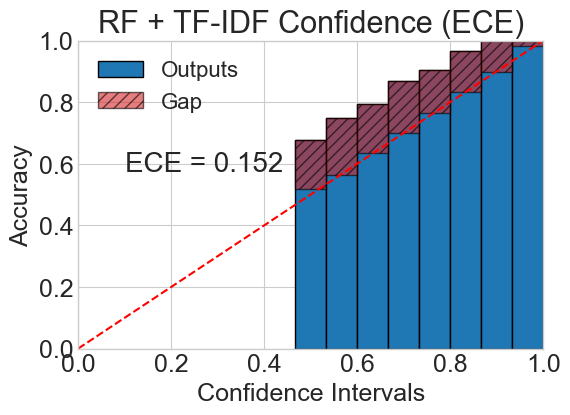


Expected Calibration Error (ECE) for model 'mlscikit-learn': 15.18%

--- Analisando o modelo BERT ---
27/27 [==============================] - 48s 2s/step


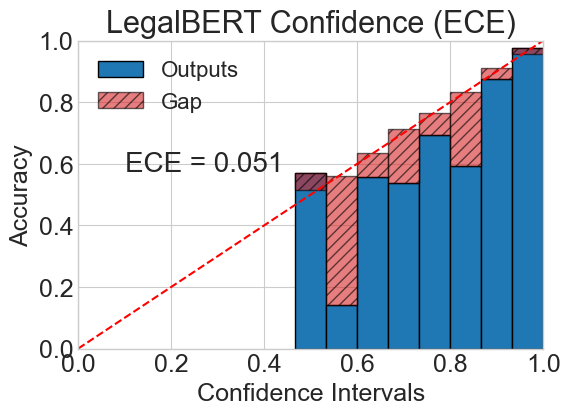


Expected Calibration Error (ECE) for model 'bert': 5.06%

--- Analisando o modelo BERT ---
27/27 [==============================] - 47s 2s/step


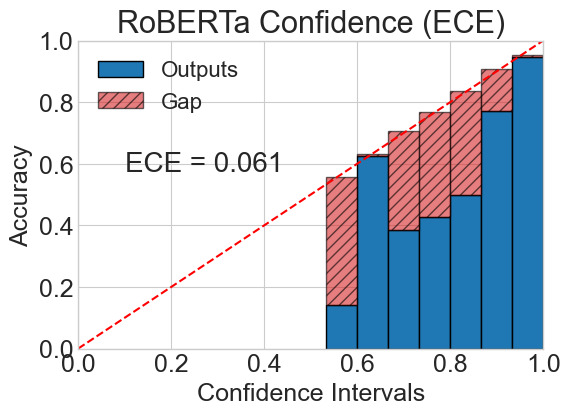


Expected Calibration Error (ECE) for model 'bert': 6.07%

--- Analisando o modelo Logistic Regression ---


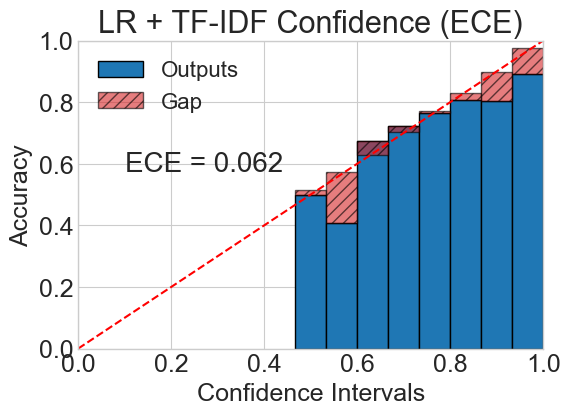


Expected Calibration Error (ECE) for model 'mlscikit-learn': 6.21%


In [76]:
print("\n--- Analisando o modelo Random Forest ---")
analyze_calibration(
    model=rf_pipeline,
    X_test=X_test_rf,
    y_test=y_test_rf,
    model_type='mlscikit-learn',
    plot_title='RF + TF-IDF Confidence (ECE)',  
    model_name = "RF + TF-IDF",
    filename='RF_calibration_plot.png'
)

print("\n--- Analisando o modelo BERT ---")
analyze_calibration(
    model=bert_model,
    X_test=bert_test_dataset,
    y_test=test_labels_bert, # Aqui está a correção
    model_type='bert',
    plot_title='LegalBERT Confidence (ECE)',
    model_name = "LegalBERT",
    filename='LegalBERT_calibration_plot.png'
)

print("\n--- Analisando o modelo BERT ---")
analyze_calibration(
    model=RoBERTa_model,
    X_test=RoBERTa_test_dataset,
    y_test=test_labels_bert, 
    model_type='bert',
    plot_title='RoBERTa Confidence (ECE)',
    model_name = "RoBERTa",
    filename='RoBERTa_calibration_plot.png'

)


print("\n--- Analisando o modelo Logistic Regression ---")
analyze_calibration(
    model=lr_pipeline,
    X_test=X_test_rf,
    y_test=y_test_rf,
    model_type='mlscikit-learn',
    plot_title='LR + TF-IDF Confidence (ECE)',
    model_name = "LR + TF-IDF",
    filename='LR_calibration_plot.png'
)



--- Analisando o modelo Logistic Regression ---


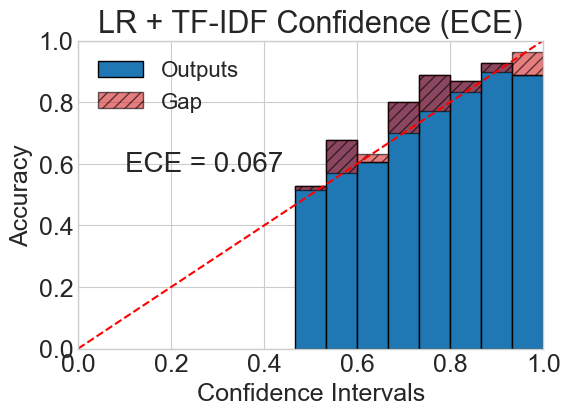


Expected Calibration Error (ECE) for model 'mlscikit-learn': 6.66%


In [82]:

print("\n--- Analisando o modelo Logistic Regression ---")
analyze_calibration(
    model=lr_pipeline,
    X_test=X_test_rf,
    y_test=y_test_rf,
    model_type='mlscikit-learn',
    plot_title='LR + TF-IDF Confidence (ECE)',
    model_name = "LR + TF-IDF",
    filename='LR_calibration_plot.png'
)


In [80]:
lr_pipeline = joblib.load('best_lr_pipeline.pkl')

In [220]:
d = pd.read_csv('gemini_test_set.csv')
c = pd.read_csv('rotulos_gemini_test_set.csv')

In [192]:
c.columns

Index(['opinion', 'name', 'modern slavery', 'modern slavery in supply chain',
       'good production', 'service production', 'plaintiff names',
       'defendant names', 'related to agriculture', 'related to hospitality',
       'related to technology', 'related to manufacturing',
       'related to service industry', 'human trafficking', 'forced labor',
       'child labor', 'sex trafficking', 'drug trafficking',
       'block1_full_text'],
      dtype='object')

In [216]:
c['modern slavery in supply chain'] = c['modern slavery in supply chain'].apply(lambda x: 1 if 'yes' else 'no')

In [226]:
d.columns

Index(['Unnamed: 0', 'id', 'content', 'target'], dtype='object')

In [ ]:
merged_df = c.merge(d, left_on='opinion', right_on='id')





